# Contents

- [Strava API](#Strava-API)
    - [Swagger Client](#Swagger-Client)
    - [Getting Over the Humps](#Getting-Over-the-Humps)
    - [Test Working](#Test-WOrking)
- [List Activites](#List-Activities)
- [Data Analysis](#Data-Analysis)
    - [Statistics](#Statistics)
    - [Plots](#Plots)
- [Geographic Data](#Geographic-Data)
    - [Matplotlib](#Matplotlib)
    - [Altair (Vega Lite / D3)](#Altair-(Vega-Lite-%2F-D3))

# Strava API

The official Strava API docs are here https://developers.strava.com/docs/  
 
First go and create a free application to generate your access token. Go here https://www.strava.com/settings/api  

I have already done this and defined my access token as an environment variable, called `STRAVA_ACCESS_TOKEN`.  

In [1]:
import os

In [2]:
strava_access_token = os.environ['STRAVA_ACCESS_TOKEN']

## Swagger Client

You interface with Strava's API via [Swagger, and the OpenAPI Specification](https://swagger.io/docs/specification/about/).

Using a Swagger API comes with a few prequequisites, including the [Swagger CodeGen Command Line Interface (CLI)](https://github.com/swagger-api/swagger-codegen), and the [Java Runtime Environment (JRE)](https://www.oracle.com/technetwork/java/javase/downloads).  

After you have Swagger CodeGen and JRE installed, test everything is working with the following:  

```shell
# (Windows)
java -jar resources/swagger-codegen-cli.jar help
```

Now you need to generate the Strava Swagger API locally to be able to use it. Run the following command:  

```shell
# (Windows)
java -jar swagger-codegen-cli.jar generate -i https://developers.strava.com/swagger/swagger.json -l python
```

This will download the API specification as a Python library in a folder called `swagger_client`.  


In [3]:
import swagger_client

In [4]:
swagger_client.configuration.access_token = strava_access_token

## Getting Over the Humps

Surprisingly, this took a bit longer than I hoped to figure everything out. Here are a few issues I ran into and how to solve them.  

### Issue 1

The examples on Strava website assume your code is running from the same directory you generated the swagger API, where `swagger_client` can be a "relative import", otherwise you will need to add the `swagger_client` folder to your `Python PATH`.

### Issue 2

Bug in the Strava Python examples. If you are using Python 3 ignore this, but if you are using Python 2 the following code in the examples is incorrect.  

```python
from __future__ import print_statement
```

Change it to.  

```python
from __future__ import print_function
```

### Issue 3

Another bug in Strava Python examples.

You must define every API class before using it. And it appears that every time we instantiate a new module, it resets the access token to a empty string.  

Setting the access token at the client level, then providing the authenticated client with the following, also does not seem to work.  
```python
swagger_client.configuration.access_token = strava_access_token
api_instance = swagger_client.AthletesApi(api_client=swagger_client)
```

You can try and hardcode your access_token into the swagger `configuration.py`, and maybe this is what Strava assumes you do, but this is probably not a good idea.  

Alternatively it may be possible to provide the access token in `config.json` when building the swagger api with the `-c` keyword argument, but I could not get this to work.  

## Test Working

Okay, we got it working.

In [5]:
from swagger_client.rest import ApiException

In [6]:
api_instance = swagger_client.AthletesApi()

In [7]:
api_instance.api_client.configuration.access_token = strava_access_token

In [8]:
try: 
    r = api_instance.get_logged_in_athlete()
except ApiException as e:
    print(e)

In [9]:
athlete_id = r.id
print(athlete_id)

2164216


In [10]:
r.shoes

[{'distance': 775728.0,
  'id': 'g187719',
  'name': 'Nike',
  'primary': True,
  'resource_state': 2}]

In [11]:
r.bikes

[{'distance': 746918.0,
  'id': 'b892090',
  'name': "GF 29'er",
  'primary': True,
  'resource_state': 2}, {'distance': 855093.0,
  'id': 'b892097',
  'name': 'Sweet Felt',
  'primary': False,
  'resource_state': 2}]

# List Activities

Let's get all my activities, using pagination, at 30 activites per page. **If you know you have A LOT of activities, you should probably set some limit here.**

In [12]:
api_instance = swagger_client.ActivitiesApi()
api_instance.api_client.configuration.access_token = strava_access_token

results = []
i = 1
while True:
    print('page:',i)
    activities = api_instance.get_logged_in_athlete_activities(page=i, per_page=30)
    if activities:
        results.append(activities)
        i+=1
    else:
        break

page: 1
page: 2
page: 3
page: 4
page: 5
page: 6
page: 7


In [13]:
# flatten the list of lists
activities = [a for r in results for a in r]

In [14]:
len(activities)

178

In [15]:
activities[0].start_date

datetime.datetime(2018, 10, 13, 11, 59, 27, tzinfo=tzutc())

In [16]:
activities[-1].start_date

datetime.datetime(2013, 3, 6, 3, 38, 23, tzinfo=tzutc())

In [17]:
#activities[0]

# Data Analysis

Let's quickly bring this into Pandas to get summarize the data.  

Using the definitions provided by Strava [here on Detailed Activity Model](https://developers.strava.com/docs/reference/#api-models-DetailedActivity).  

In [18]:
import pandas as pd

In [19]:
records = [a.to_dict() for a in activities]

In [20]:
df = pd.DataFrame.from_records(records)

In [21]:
df.shape

(178, 39)

### Preview

In [22]:
df.head(2)

,achievement_count,athlete,athlete_count,average_speed,average_watts,comment_count,commute,device_watts,distance,elapsed_time,...,start_date_local,start_latlng,timezone,total_elevation_gain,total_photo_count,trainer,type,upload_id,weighted_average_watts,workout_type
0,27,{'id': 2164216},1,5.641,168.8,0,False,False,30365.9,8725,...,2018-10-13 13:59:27+00:00,"[52.14, 4.48]",(GMT+01:00) Europe/Amsterdam,49.4,1,False,Ride,2.036541e+09,None,10.0
1,9,{'id': 2164216},1,3.012,NaN,0,False,None,10653.3,3744,...,2018-09-29 15:03:25+00:00,"[52.15, 4.49]",(GMT+01:00) Europe/Amsterdam,52.9,0,False,Run,2.006422e+09,None,3.0


### Conversions

In [23]:
# convert distance in meters to kilometers
df.loc[:,'distance'] = df.distance / 1000

# convert moving in seconds time to minutes
df.loc[:,'moving_time'] = df.moving_time / 60

# convert average speed in meters per second to minutes per kilometer
df.loc[:,'average_speed_mpk'] = 16.666 / df.average_speed

# create new column average speed in kilometers per hour
df.loc[:,'average_speed_kph'] = 60 / df.average_speed_mpk

### Formatting

In [24]:
# format date to be used in plot labels
df.loc[:,'start_date_formatted'] = df.start_date.dt.strftime('%b %Y')

## Statistics

In [25]:
df.type.value_counts()

Run          137
Ride          38
Hike           2
AlpineSki      1
Name: type, dtype: int64

In [26]:
df.groupby('type')\
    [['average_speed_mpk',
      'average_speed_kph',
      'distance','moving_time',
      'total_elevation_gain',
      'achievement_count']]\
    .agg(['mean','max'])\
    .T

type                       AlpineSki        Hike         Ride         Run
average_speed_mpk    mean   2.662300   11.130909     2.971785    5.640177
                     max    2.662300   14.159728     6.864086    7.271379
average_speed_kph    mean  22.536901    5.821433    21.360981   10.727615
                     max   22.536901    7.405496    27.739110   13.500540
distance             mean   6.348000    7.263100    51.447458    5.953531
                     max    6.348000    9.464000   121.092000   12.309700
moving_time          mean  16.900000   74.175000   143.996491   33.660827
                     max   16.900000   76.666667   341.583333   85.733333
total_elevation_gain mean   3.600000  209.700000   273.378947   25.176642
                     max    3.600000  405.100000  1370.300000  393.000000
achievement_count    mean   0.000000    0.000000     7.473684    1.401460
                     max    0.000000    0.000000    40.000000    9.000000

In [27]:
df.groupby('timezone').type.value_counts().to_frame()

type
timezone                      type           
(GMT+01:00) Europe/Amsterdam  Run          80
                              Ride          8
                              Hike          1
(GMT+01:00) Europe/Vienna     AlpineSki     1
(GMT+08:00) Asia/Kuala_Lumpur Hike          1
                              Run           1
(GMT+08:00) Asia/Singapore    Ride          9
                              Run           1
(GMT-06:00) America/Chicago   Run          55
                              Ride         21

## Plots

For visualizations in this notebook i am using a library called Altair. For more on that see https://altair-viz.github.io/

In [28]:
import altair as alt

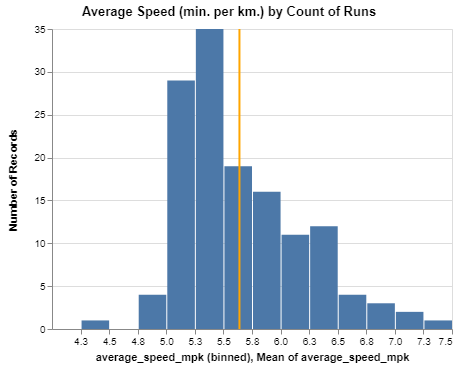

In [29]:
data = df.loc[df.type=='Run',:]

bar = alt.Chart(data).mark_bar().encode(
    alt.X('average_speed_mpk:Q', bin=alt.Bin(step=.25)),
    alt.Y('count()'),
)

bar.title = 'Average Speed (min. per km.) by Count of Runs'

rule = alt.Chart(data).mark_rule(color='orange').encode(
    x='mean(average_speed_mpk):Q',
    size=alt.value(2)
)

bar + rule

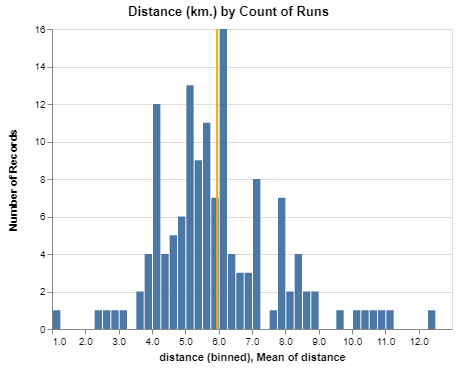

In [30]:
data = df.loc[df.type=='Run',:]

bar = alt.Chart(data).mark_bar().encode(
    alt.X('distance:Q', bin=alt.Bin(step=.25)),
    alt.Y('count()')
)

bar.title = 'Distance (km.) by Count of Runs'

rule = alt.Chart(data).mark_rule(color='orange').encode(
    x='mean(distance):Q',
    size=alt.value(2)
)

bar + rule

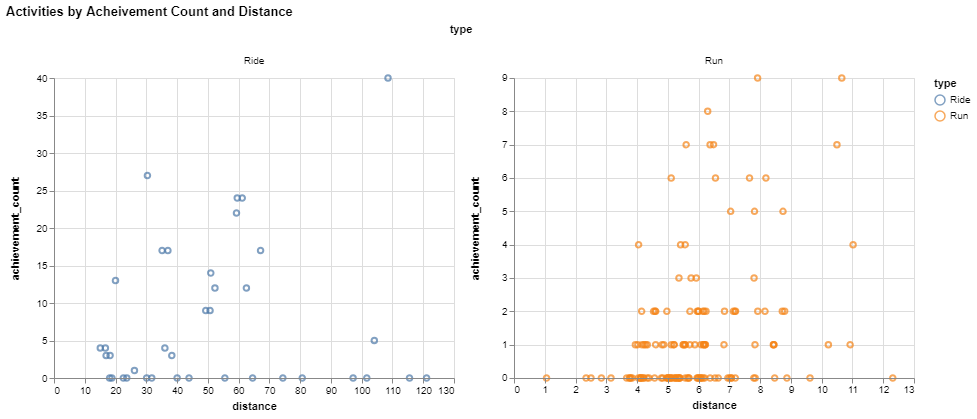

In [31]:
data = df.loc[df['type'].isin(['Run','Ride']),:]

chart = alt.Chart(data).transform_calculate(
    url='https://www.strava.com/activities/' + alt.datum.id
).mark_point().encode(
    x='distance',
    y='achievement_count',
    color='type',
    href='url:N'
).facet(
    column='type'
).resolve_scale(
    x='independent',
    y='independent'
)

chart.title = 'Activities by Acheivement Count and Distance'

chart

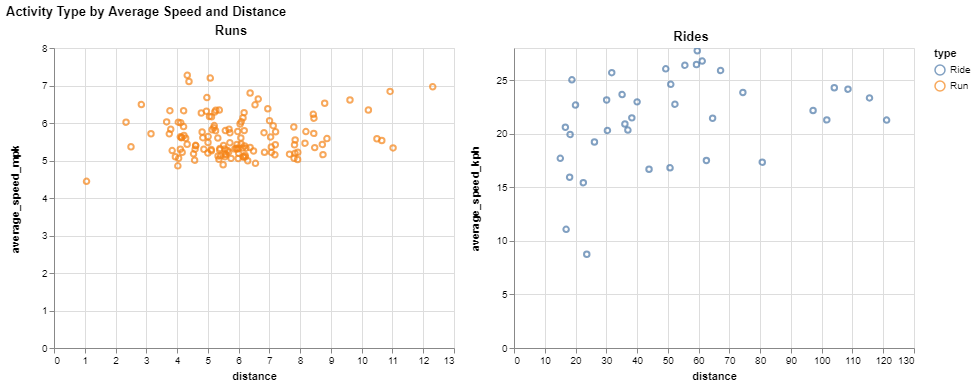

In [32]:
data_run = df.loc[df['type'] == 'Run',:]

chart_run = alt.Chart(data_run).transform_calculate(
    url='https://www.strava.com/activities/' + alt.datum.id
).mark_point().encode(
    x='distance',
    y='average_speed_mpk',
    color='type',
    href='url:N'
).interactive()

chart_run.title = 'Runs'

data_ride = df.loc[df['type'] == 'Ride',:]

chart_ride = alt.Chart(data_ride).transform_calculate(
    url='https://www.strava.com/activities/' + alt.datum.id
).mark_point().encode(
    x='distance',
    y='average_speed_kph',
    color='type',
    href='url:N'
).interactive()

chart_ride.title = 'Rides'

chart = alt.hconcat(chart_run, chart_ride)

chart.title = 'Activity Type by Average Speed and Distance'

chart

# Geographic Data

Strava provides here a summarized version of each activity. As well the route map is summarized as a simple list of latitue and longitude coordinates, and encoded using [Google's Polyline Algorithm](https://developers.google.com/maps/documentation/utilities/polylinealgorithm).

Handy enough, there is a [polyline library in Python](https://github.com/hicsail/polyline) which we can use to decode this. Get it with `pip install polyline`

In [33]:
import polyline

In [34]:
coo = polyline.decode(activities[0].map.summary_polyline)

In [35]:
coo[:10]

[(52.13785, 4.48148),
 (52.13752, 4.48058),
 (52.13688, 4.48019),
 (52.13516, 4.47454),
 (52.13386, 4.47319),
 (52.13424, 4.47224),
 (52.13315, 4.46941),
 (52.13099, 4.46808),
 (52.12667, 4.46395),
 (52.1253, 4.46602)]

Now we can apply basic plotting techniques to represent the coordinates geographically, to get something that looks similar to https://www.strava.com/heatmap. **Just an FYI, viewing personal heatmaps in Strava is a paid feature(!)**  

A simple way to do this in Python is start with a basic Matplotlib canvas.  

Since the activies are so far unfiliterd, and I know I have recorded activies in various parts of the world, let's apply some basic filtering to get valid activity coordinates from general geographic locations of interest (using rounding of coordincates).

I'm not going to show too many details here, and adding backgrounds to maps is complicated. However, this can be personally very interesting to see which neighborhoods or routes you favor over others by just glancing this over.

## Matplotlib

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Des Moines, IA USA

In [37]:
coo_list = [polyline.decode(x.map.summary_polyline) for x in activities 
            if x.timezone == '(GMT-06:00) America/Chicago'
            and x.start_latlng is not None
            and x.start_latlng[0] <= 41.6 and round(x.start_latlng[0],1) >= 41.2 and round(x.start_latlng[1]) == -94]

In [38]:
print('Activities:', len(coo_list))

Activities: 55


In [39]:
coo_list[0]

[(41.55954, -93.76942),
 (41.55934, -93.76753),
 (41.55973, -93.76617),
 (41.56677, -93.75993),
 (41.56749, -93.75882),
 (41.56727, -93.75842),
 (41.56757, -93.7567),
 (41.56511, -93.75665),
 (41.56194, -93.75227),
 (41.55948, -93.75203),
 (41.55934, -93.76408),
 (41.56013, -93.76569),
 (41.55942, -93.7675),
 (41.55942, -93.76943)]

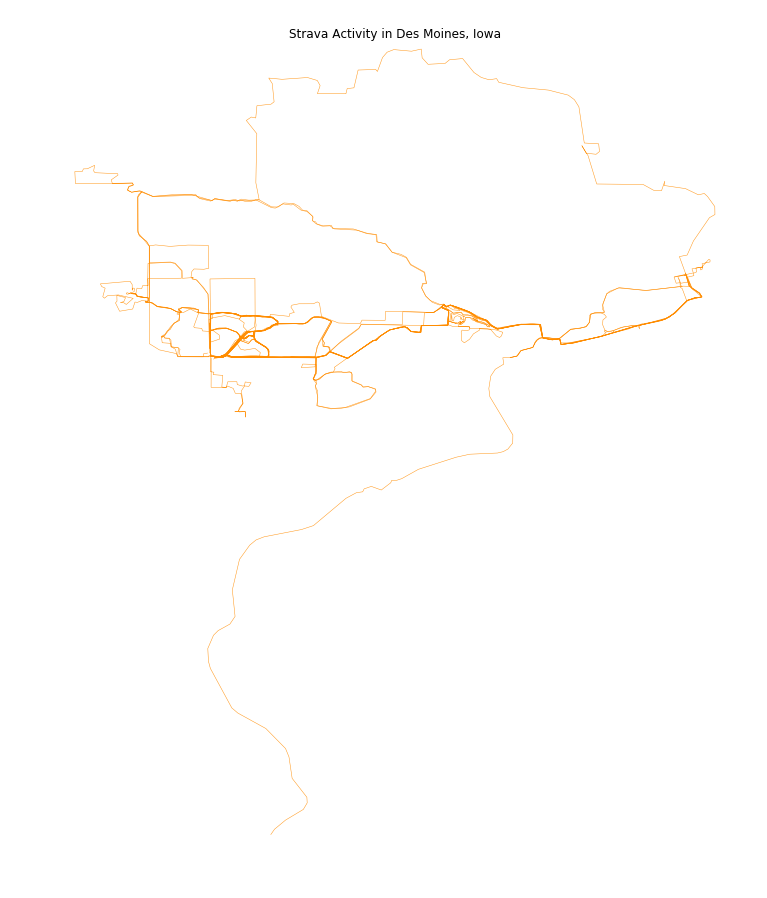

In [40]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('Strava Activity in Des Moines, Iowa')
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)

for coo in coo_list:
    lat,lon = map(list, zip(*coo))
    plt.plot(lon, lat, color='darkorange', lw=0.5, alpha=.9)

## Altair (Vega Lite / D3)

To do the same thing in Altair, we need to get the data into a format required by d3, preferably the compressed geo file format `topojson`.  

The steps taken are then the following:
1. Transform data in Python using
    - decode the polylines into list of longitute latitude
    - convert list of longitute latitude to list of `Shapely` Points
    - convert list of points into `Shapely` LineStrings
    - convert `Pandas` DataFrame with LineStrings and metadata to `GeoPandas` DataFrame
2. Export as `GeoJson`
3. Convert `GeoJSON` to `TopoJSON` using `geo2topo`
```shell
geo2topo -q 1e6 line=geojson.json > topojson.json
```
4. Import topojson into `Altair` and plot

Requirements:
- GeoPandas and dependencies http://geopandas.org/install.html
- TopoJSON Server https://github.com/topojson/topojson-server#installing

Caveats:
- at time of writing we cannot add hover tooltips in Altair because Vega Lite does not yet support interactive geoshapes (follow the issue here https://github.com/altair-viz/altair/issues/679)

Background Reading:
- for more on how D3 uses TopoJSON read Mike Bostock's [Command Line Cartography](https://medium.com/@mbostock/command-line-cartography-part-1-897aa8f8ca2c) (formerly [Let's Make a Map](https://bost.ocks.org/mike/map/))

In [41]:
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString

def decode_map(x):
    if not x['summary_polyline'] == None:
        return polyline.decode(x['summary_polyline'])

### Des Moines, IA USA

In [42]:
df_tmp = df.loc[df.timezone == '(GMT-06:00) America/Chicago',:]
df_tmp = df_tmp.loc[df.start_latlng.apply(lambda x: round(x[0],1) <= 41.6  and round(x[0],1) >= 41.2 and round(x[1]) == -94 if not x == None else False),:]

In [43]:
df_tmp.loc[:,'map_decoded'] = df_tmp.loc[:,'map'].apply(decode_map)

df_tmp.loc[:,'geometry_list'] = df_tmp.loc[:,'map_decoded'].apply(lambda d: [Point(y,x) for x,y in d] if not d == None else pd.np.nan)

df_map = df_tmp.loc[df_tmp.geometry_list.isnull() == False,:]

df_map.loc[:,'geo_line'] = df_map.loc[:,'geometry_list'].apply(LineString)

gdf = GeoDataFrame(df_map[['type','geo_line']], geometry='geo_line')

In [44]:
gdf.head()

,type,geo_line
60,Run,"LINESTRING (-93.76942 41.55954, -93.7675299999..."
63,Run,"LINESTRING (-93.76782 41.55941, -93.7664099999..."
64,Run,"LINESTRING (-93.77070000000001 41.56226, -93.7..."
68,Run,"LINESTRING (-93.76779000000001 41.5594, -93.76..."
69,Run,"LINESTRING (-93.76975 41.5596, -93.76763 41.55..."


In [45]:
gdf.to_file('data/geojson.json', driver="GeoJSON")

#### now run below command to generate topojson file

```shell
geo2topo -q 1e6 line=geojson.json > topojson.json
```

In [46]:
data = alt.topo_feature('data/topojson.json', 'line')

In [47]:
data

UrlData({
  format: TopoDataFormat({
    feature: 'line',
    type: 'topojson'
  }),
  url: 'data/topojson.json'
})

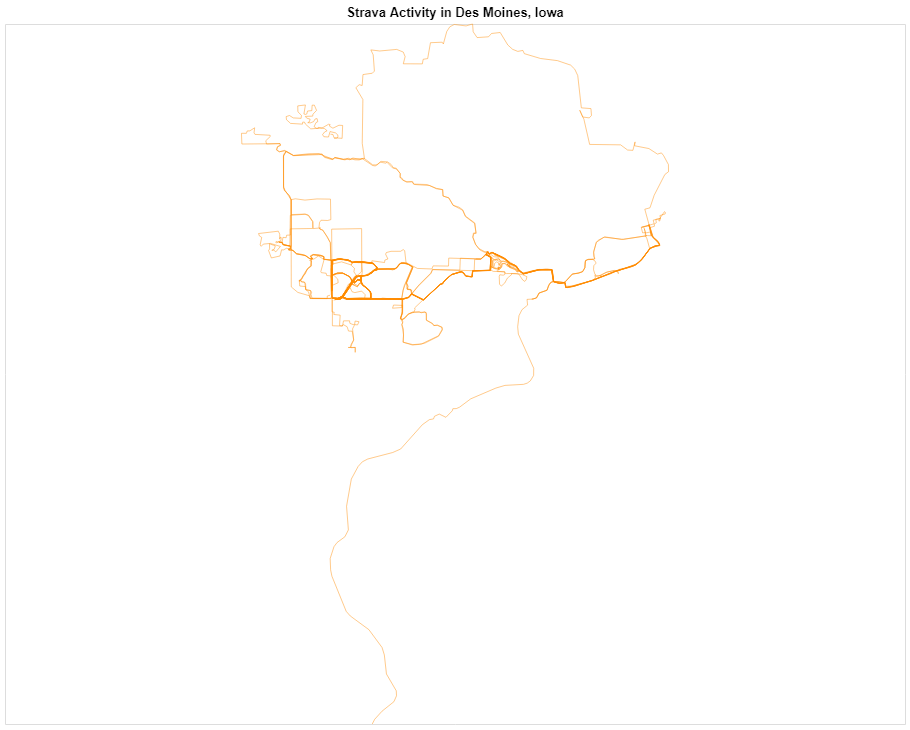

In [48]:
chart = alt.Chart(data).mark_geoshape(
    stroke='darkorange',
    strokeWidth=.5,
    opacity=.9,
    filled=False
).properties(
    title='Strava Activity in Des Moines, Iowa',
    width=900,
    height=700
)

chart